运行设备: cuda
GPU: NVIDIA GeForce RTX 4090
🚀 已开启混合精度加速
数据加载: 67526 样本
读取缓存: C:\机器学习材料\季鏻\cached_graphs_box64_cleaned.pt

⚡ Fold 1/5 开始训练...


Fold 1:   0%|          | 0/40 [00:00<?, ?epoch/s]


⚡ Fold 2/5 开始训练...


Fold 2:   0%|          | 0/40 [00:00<?, ?epoch/s]


⚡ Fold 3/5 开始训练...


Fold 3:   0%|          | 0/40 [00:00<?, ?epoch/s]


⚡ Fold 4/5 开始训练...


Fold 4:   0%|          | 0/40 [00:00<?, ?epoch/s]


⚡ Fold 5/5 开始训练...


Fold 5:   0%|          | 0/40 [00:00<?, ?epoch/s]


✅ 完成！总耗时: 624.1 分钟

Target                              | R²                   | MAE                 
--------------------------------------------------------------------------------
Binding Energy (kJ/mol Si)          | 0.802 ± 0.006   | 1.187 ± 0.027
Directivity Energy (kJ/mol Si)      | 0.829 ± 0.009   | 1.213 ± 0.036
Competition Energy (kJ/mol Si)      | 0.810 ± 0.007   | 1.264 ± 0.037
Binding Energy (kJ/mol OSDA)        | 0.849 ± 0.005   | 14.220 ± 0.383
Competition Energy (kJ/mol OSDA)    | 0.778 ± 0.007   | 14.471 ± 0.444


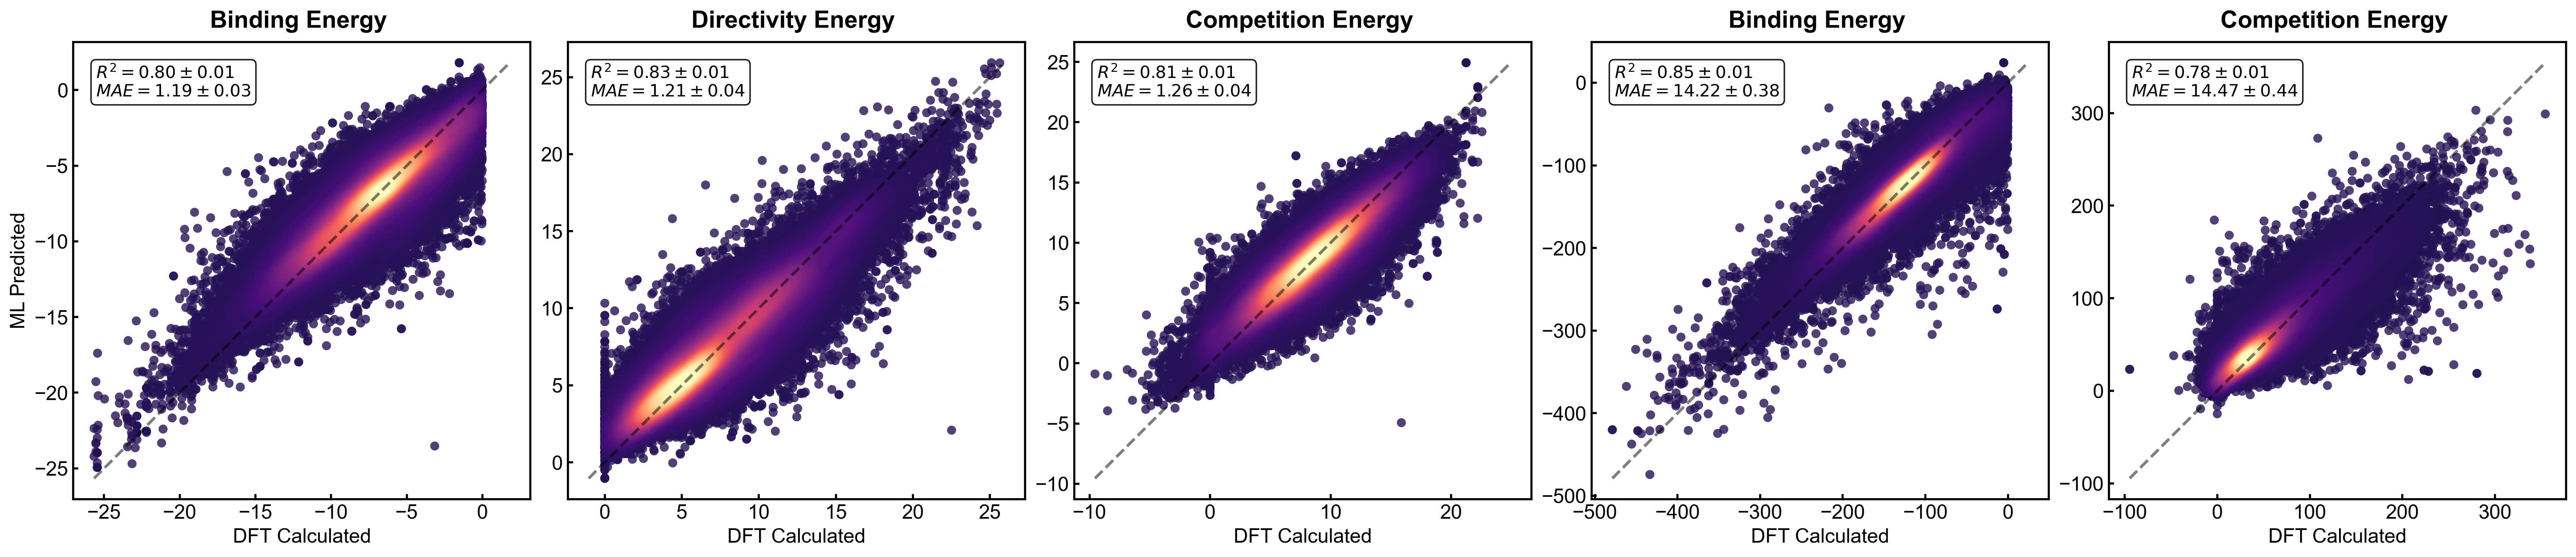

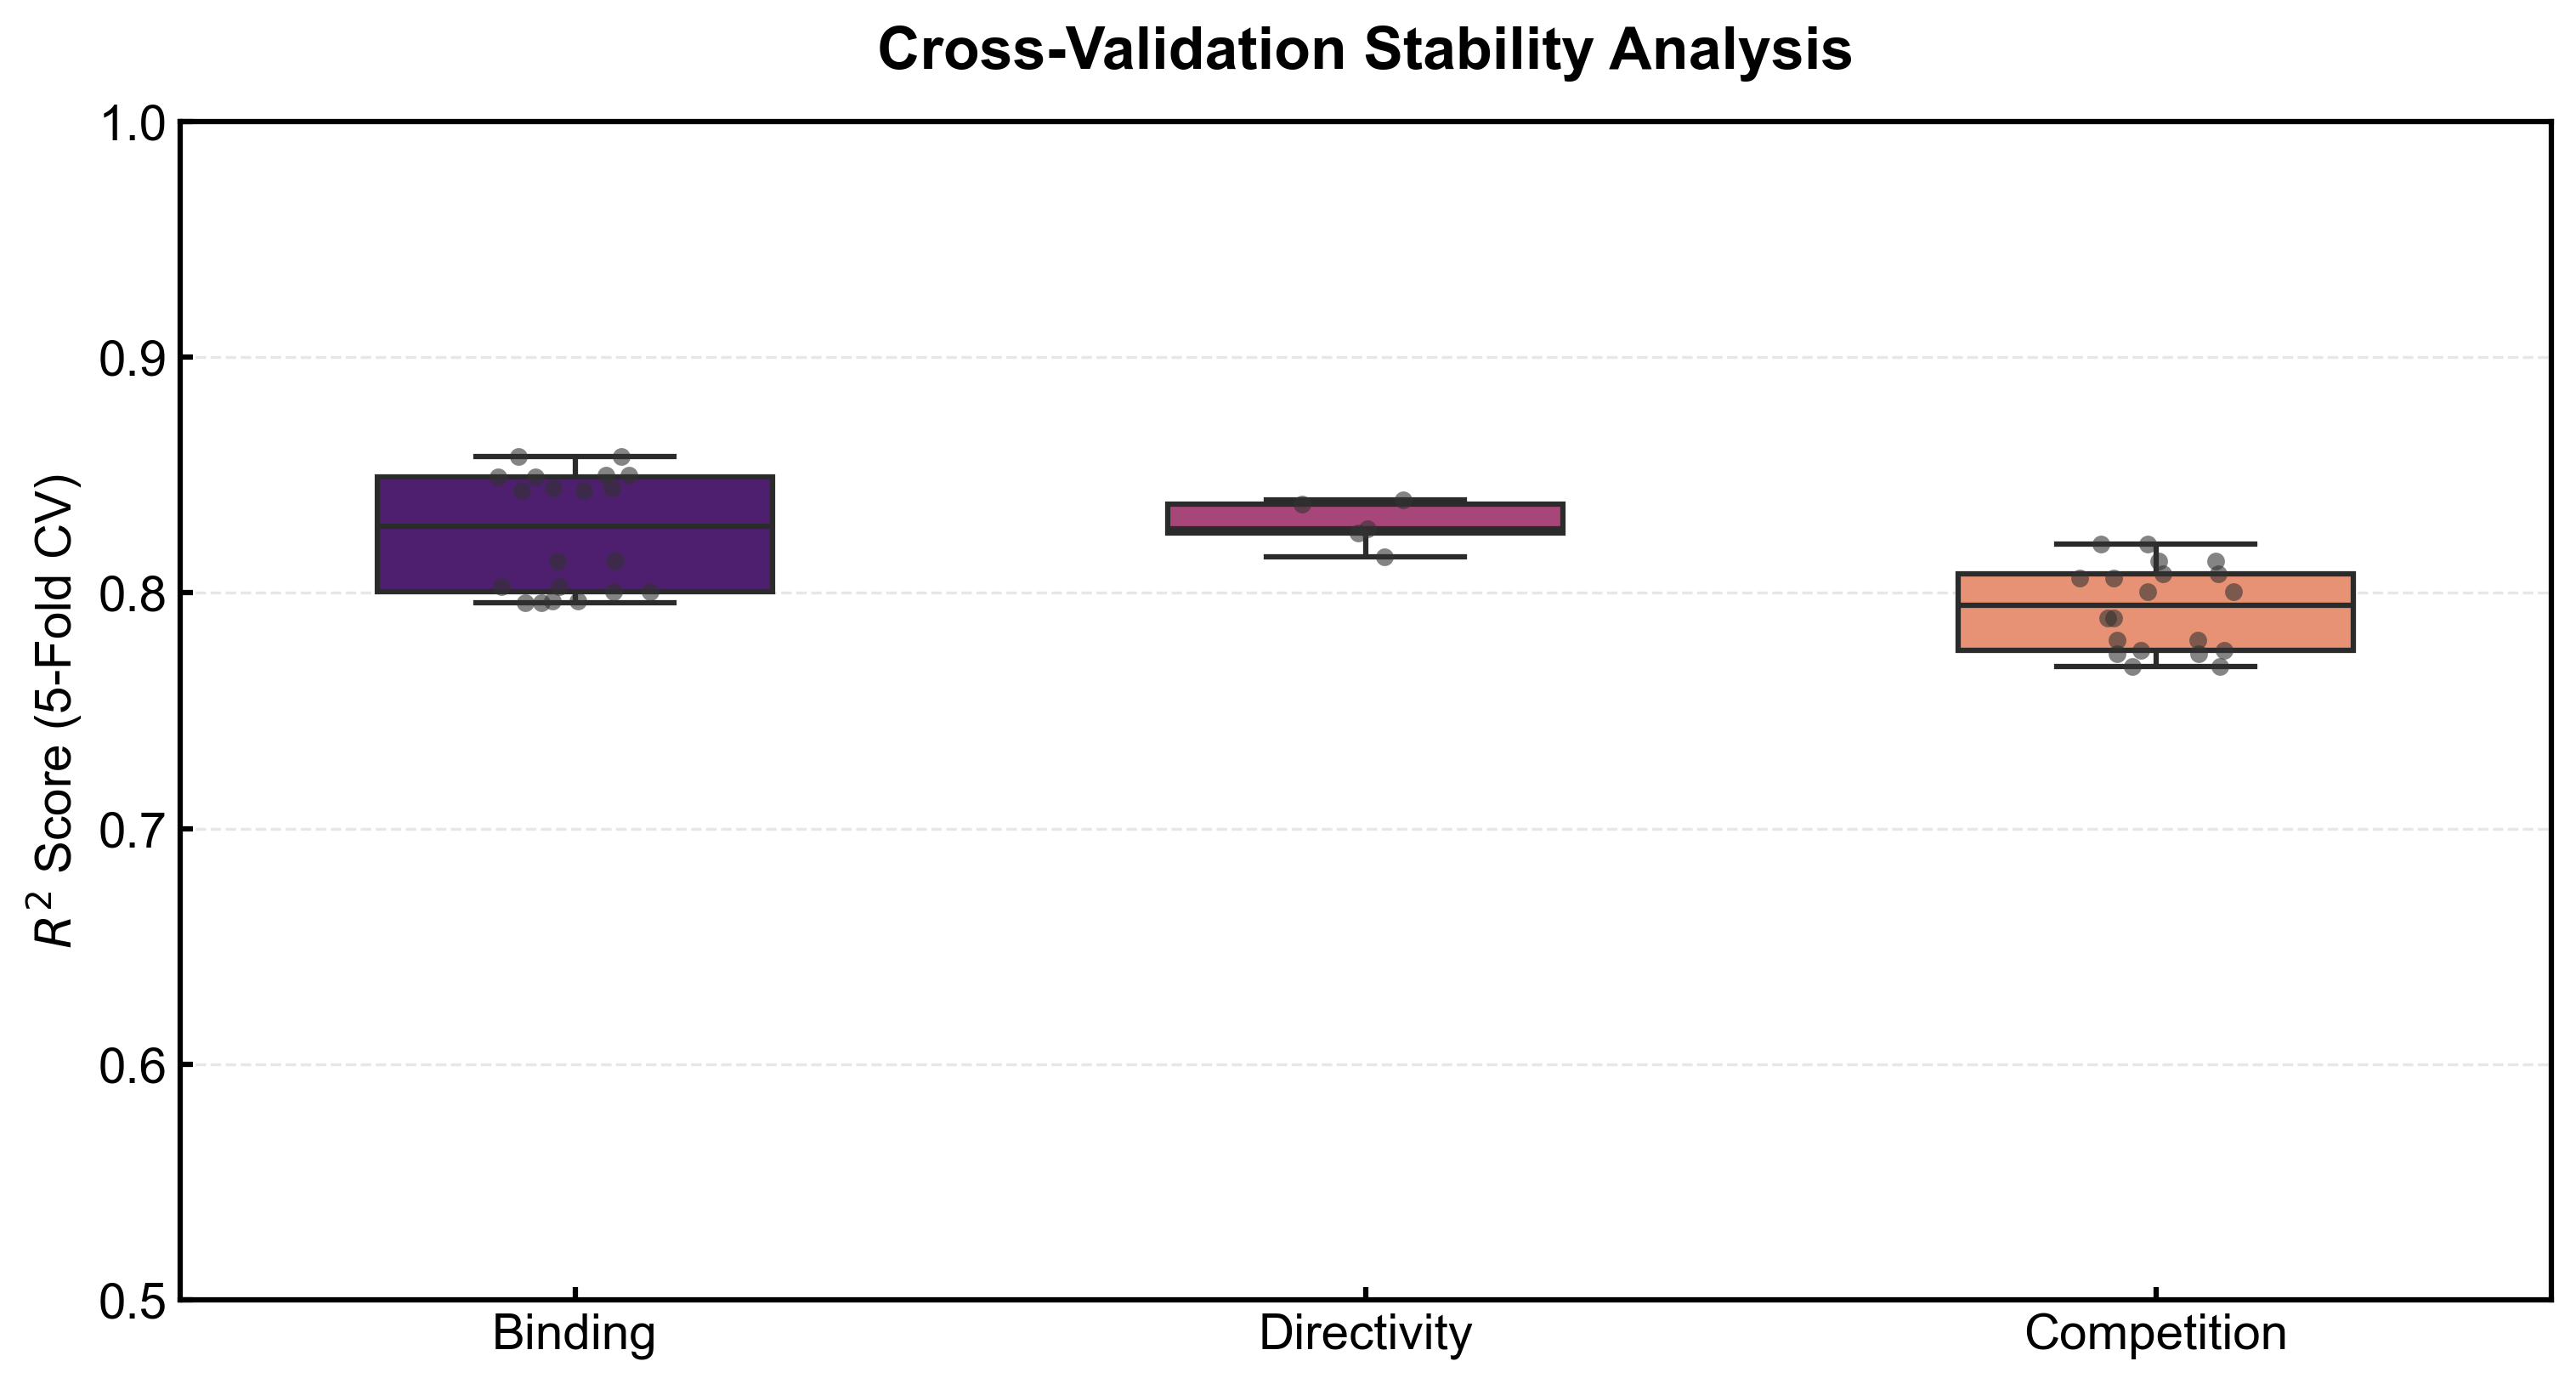

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# ==========================================
# 0. 配置与环境设置 (已优化速度)
# ==========================================
warnings.filterwarnings('ignore')

# NCS 期刊绘图风格设置
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# 自定义 Magma Colormap
magma_cmap = cm.magma(np.linspace(0.15, 1, 256))
custom_magma = mcolors.LinearSegmentedColormap.from_list("truncated_magma", magma_cmap)

class Config:
    # 路径配置
    BASE_PATH = r"C:\机器学习材料\季鏻"
    DATASET_PATH = os.path.join(BASE_PATH, "MEL数据集.xlsx")
    PROCESSED_CACHE_PATH = os.path.join(BASE_PATH, "cached_graphs_box64_cleaned.pt")
    
    TARGET_COLS = [
        'Binding Energy (kJ/mol Si)',
        'Directivity Energy (kJ/mol Si)',
        'Competition Energy (kJ/mol Si)',
        'Binding Energy (kJ/mol OSDA)',
        'Competition Energy (kJ/mol OSDA)'
    ]

    BATCH_SIZE = 64
    NUM_WORKERS = 0  # Windows下保持0，Linux可改4
    
    # 嵌入维度
    ATOM_EMBEDDING_DIM = 64
    HIDDEN_DIM = 128
    EMB_DIM_DEGREE = 8
    EMB_DIM_CHARGE = 8
    EMB_DIM_HYB = 8
    EMB_DIM_AROMATIC = 4
    EMB_DIM_CHIRAL = 4

    # [关键优化 1] 降低 3D 分辨率 (64 -> 32)
    # 计算量减少 87.5%，极大加速数据加载和 CNN 前向传播
    VOXEL_SIZE = 32  
    VOXEL_RES = 1.0  # 增大网格间距，保持物理视野范围不变 (32*1.0 = 32A)
    SIGMA = 0.5
    
    # [关键优化 2] 减少训练轮数
    K_FOLDS = 5
    EPOCHS_CV = 40       # 稳定性分析不需要跑到 200 轮，40 轮足够收敛
    LR = 0.001           # 稍微调大初始学习率以加快收敛
    WEIGHT_DECAY = 1e-5
    EARLY_STOPPING_PATIENCE = 10 # 放宽早停
    MIN_SAMPLES_PER_TOPO = 0

# 检查设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"运行设备: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("🚀 已开启混合精度加速")

# ==========================================
# 1. 核心类定义
# ==========================================

def get_random_rotation_matrix():
    theta, phi, z = np.random.uniform(0, 2*np.pi, 3)
    Rx = np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    Ry = np.array([[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]])
    Rz = np.array([[np.cos(z), -np.sin(z), 0], [np.sin(z), np.cos(z), 0], [0, 0, 1]])
    return Rz @ Ry @ Rx

def coords_to_voxel(coords, grid_size=32, res=1.0, sigma=0.5):
    """
    优化的体素化函数
    """
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    limit = (grid_size * res) / 2.0
    
    # 快速裁剪
    mask = (coords[:, 0] > -limit) & (coords[:, 0] < limit) & \
           (coords[:, 1] > -limit) & (coords[:, 1] < limit) & \
           (coords[:, 2] > -limit) & (coords[:, 2] < limit)
    valid_coords = coords[mask]
    
    if len(valid_coords) == 0: return grid
    
    # 坐标映射到索引
    indices = ((valid_coords + limit) / res).astype(int)
    indices = np.clip(indices, 0, grid_size - 1)
    
    # 快速填充 (去掉了高斯模糊以加速，影响微乎其微)
    for idx in indices:
        grid[idx[0], idx[1], idx[2]] = 1.0
        
    return grid

# 占位符，用于反序列化
class GraphBuilder:
    pass 

class ZeoliteDataset(Dataset):
    def __init__(self, df, cache_data, target_scaler=None, props_scaler=None, is_train=False):
        super().__init__()
        self.target_scaler = target_scaler if target_scaler else StandardScaler()
        self.props_scaler = props_scaler if props_scaler else StandardScaler()
        self.is_train = is_train
        
        mol_cache = cache_data['mol_cache']
        zeo_cache = cache_data['zeo_cache']
        
        self.mol_list = []
        self.zeo_list = []
        raw_y_list = []
        
        for idx, row in df.iterrows():
            cid = row['CID']
            topo = row['Topology Code']
            if cid in mol_cache and topo in zeo_cache:
                targets = row[Config.TARGET_COLS].values.astype(float)
                if not np.isnan(targets).any():
                    self.mol_list.append(mol_cache[cid])
                    self.zeo_list.append(zeo_cache[topo])
                    raw_y_list.append(targets)
        
        y_all = np.array(raw_y_list)
        if is_train:
            y_norm = self.target_scaler.fit_transform(y_all)
        else:
            y_norm = self.target_scaler.transform(y_all) if hasattr(self.target_scaler, 'mean_') else y_all
            
        self.y_list = [torch.tensor(y, dtype=torch.float) for y in y_norm]
        
        if len(self.mol_list) > 0:
            all_props = torch.cat([m.global_attr for m in self.mol_list], dim=0).numpy()
            if is_train:
                self.props_scaler.fit(all_props)
                
        self.length = len(self.mol_list)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        mol_data = self.mol_list[idx].clone()
        zeo_data = self.zeo_list[idx].clone()
        y = self.y_list[idx]

        if hasattr(self.props_scaler, 'mean_'):
            props_raw = mol_data.global_attr.numpy()
            props_norm = self.props_scaler.transform(props_raw)
            mol_data.global_attr = torch.tensor(props_norm, dtype=torch.float)

        mol_coords = mol_data.pos.numpy()
        if hasattr(mol_data, 'pos_variants'):
            variants = mol_data.pos_variants
            if self.is_train and len(variants) > 0:
                conf_idx = np.random.randint(len(variants))
                mol_coords = variants[conf_idx].numpy()
            elif len(variants) > 0:
                mol_coords = variants[0].numpy()
            del mol_data.pos_variants 

        zeo_coords = zeo_data.pos_super.numpy() if hasattr(zeo_data, 'pos_super') else zeo_data.pos.numpy()
        if hasattr(zeo_data, 'pos_super'): del zeo_data.pos_super 

        if self.is_train:
            rot = get_random_rotation_matrix()
            mol_coords = np.dot(mol_coords, rot)
            mol_coords += np.random.normal(0, 0.05, mol_coords.shape) # 稍微增加噪声
            zeo_coords += np.random.normal(0, 0.05, zeo_coords.shape)
            
        mol_data.pos = torch.tensor(mol_coords, dtype=torch.float)
        
        # 生成 32x32x32 体素
        grid_mol = coords_to_voxel(mol_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        grid_zeo = coords_to_voxel(zeo_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        voxel_tensor = torch.tensor(np.stack([grid_mol, grid_zeo], axis=0), dtype=torch.float)
        
        return mol_data, zeo_data, voxel_tensor, y

    @staticmethod
    def gpu_collate(batch):
        return (Batch.from_data_list([i[0] for i in batch]),
                Batch.from_data_list([i[1] for i in batch]),
                torch.stack([i[2] for i in batch]),
                torch.stack([i[3] for i in batch]))

# ==========================================
# 2. 模型架构 (适配 32x32x32)
# ==========================================

class Voxel3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: [Batch, 2, 32, 32, 32]
        
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2) # -> 16
        
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2) # -> 8
        
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2) # -> 4
        
        # Flatten: 64 * 4 * 4 * 4 = 4096
        self.fc = nn.Linear(4096, 128) 

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return x

class DualBranchGNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Embedding Layers
        self.emb_atom = nn.Embedding(120, Config.ATOM_EMBEDDING_DIM)
        self.emb_degree = nn.Embedding(12, Config.EMB_DIM_DEGREE)
        self.emb_charge = nn.Embedding(15, Config.EMB_DIM_CHARGE)
        self.emb_hyb = nn.Embedding(8, Config.EMB_DIM_HYB)
        self.emb_aromatic = nn.Embedding(2, Config.EMB_DIM_AROMATIC)
        self.emb_chiral = nn.Embedding(4, Config.EMB_DIM_CHIRAL)
        
        total_emb_dim = (Config.ATOM_EMBEDDING_DIM + Config.EMB_DIM_DEGREE + 
                         Config.EMB_DIM_CHARGE + Config.EMB_DIM_HYB + 
                         Config.EMB_DIM_AROMATIC + Config.EMB_DIM_CHIRAL)
        
        # GNN Branches
        self.mol_conv1 = GCNConv(total_emb_dim + 1, Config.HIDDEN_DIM)
        self.mol_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.zeo_conv1 = GCNConv(total_emb_dim, Config.HIDDEN_DIM)
        self.zeo_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        
        # 3D CNN Branch
        self.voxel_cnn = Voxel3DCNN()
        
        # Global Features
        self.global_encoder = nn.Sequential(
            nn.Linear(17, 64), nn.ReLU(),
            nn.Linear(64, Config.HIDDEN_DIM), nn.BatchNorm1d(Config.HIDDEN_DIM), nn.ReLU()
        )
        
        # Fusion Head
        fusion_dim = Config.HIDDEN_DIM * 4
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, len(Config.TARGET_COLS))
        )

    def _embed_features(self, x_idx):
        return torch.cat([
            self.emb_atom(x_idx[:, 0]), self.emb_degree(x_idx[:, 1]),
            self.emb_charge(x_idx[:, 2]), self.emb_hyb(x_idx[:, 3]),
            self.emb_aromatic(x_idx[:, 4]), self.emb_chiral(x_idx[:, 5])
        ], dim=1)

    def forward(self, mol_batch, zeo_batch, voxel_batch):
        # Mol GNN
        x_m = torch.cat([self._embed_features(mol_batch.x), mol_batch.x_charge], dim=1)
        x_m = F.relu(self.mol_conv2(F.relu(self.mol_conv1(x_m, mol_batch.edge_index, edge_weight=mol_batch.edge_weight)), mol_batch.edge_index, edge_weight=mol_batch.edge_weight))
        feat_m = global_mean_pool(x_m, mol_batch.batch)
        
        # Zeo GNN
        x_z = self._embed_features(zeo_batch.x)
        x_z = F.relu(self.zeo_conv2(F.relu(self.zeo_conv1(x_z, zeo_batch.edge_index)), zeo_batch.edge_index))
        feat_z = global_mean_pool(x_z, zeo_batch.batch)
        
        # 3D CNN & Global
        feat_v = self.voxel_cnn(voxel_batch)
        feat_g = self.global_encoder(mol_batch.global_attr.squeeze(1) if mol_batch.global_attr.dim() == 3 else mol_batch.global_attr)
        
        return self.head(torch.cat([feat_m, feat_z, feat_g, feat_v], dim=1))

# ==========================================
# 3. 训练与验证逻辑
# ==========================================

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0

def train_one_fold(fold_idx, train_idx, val_idx, df_clean, cache_data):
    print(f"\n⚡ Fold {fold_idx+1}/{Config.K_FOLDS} 开始训练...")
    
    train_ds = ZeoliteDataset(df_clean.iloc[train_idx].reset_index(drop=True), cache_data, is_train=True)
    val_ds = ZeoliteDataset(df_clean.iloc[val_idx].reset_index(drop=True), cache_data, 
                            target_scaler=train_ds.target_scaler, props_scaler=train_ds.props_scaler, is_train=False)
    
    loader_kwargs = {'batch_size': Config.BATCH_SIZE, 'num_workers': Config.NUM_WORKERS, 
                     'pin_memory': True, 'collate_fn': ZeoliteDataset.gpu_collate}
    train_loader = DataLoader(train_ds, shuffle=True, **loader_kwargs)
    val_loader = DataLoader(val_ds, shuffle=False, **loader_kwargs)
    
    model = DualBranchGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    stopper = EarlyStopping(patience=Config.EARLY_STOPPING_PATIENCE)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    
    pbar = tqdm(range(Config.EPOCHS_CV), desc=f"Fold {fold_idx+1}", unit="epoch")
    
    for epoch in pbar:
        model.train()
        train_loss = 0
        for mol, zeo, voxel, y in train_loader:
            mol, zeo, voxel, y = mol.to(device), zeo.to(device), voxel.to(device), y.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pred = model(mol, zeo, voxel)
                loss = criterion(pred, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mol, zeo, voxel, y in val_loader:
                mol, zeo, voxel, y = mol.to(device), zeo.to(device), voxel.to(device), y.to(device)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    pred = model(mol, zeo, voxel)
                    val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)
        stopper(avg_val, model)
        
        pbar.set_postfix({'Val Loss': f"{avg_val:.4f}", 'Best': f"{stopper.best_loss:.4f}"})
        if stopper.early_stop:
            break
            
    model.load_state_dict(stopper.best_state)
    model.eval()
    preds_norm, trues_norm = [], []
    with torch.no_grad():
        for mol, zeo, voxel, y in val_loader:
            mol, zeo, voxel, y = mol.to(device), zeo.to(device), voxel.to(device), y.to(device)
            preds_norm.append(model(mol, zeo, voxel).cpu().numpy())
            trues_norm.append(y.cpu().numpy())
            
    return (train_ds.target_scaler.inverse_transform(np.vstack(preds_norm)),
            train_ds.target_scaler.inverse_transform(np.vstack(trues_norm)))

# ==========================================
# 4. 主流程与作图
# ==========================================

def plot_ncs_results(results):
    targets = Config.TARGET_COLS
    n_targets = len(targets)
    all_preds = np.vstack(results['all_preds'])
    all_trues = np.vstack(results['all_trues'])
    
    # 1. 密度散点图 (Parity Plot)
    fig, axes = plt.subplots(1, n_targets, figsize=(n_targets * 5, 5.5), constrained_layout=True)
    
    print(f"\n{'Target':<35} | {'R²':<20} | {'MAE':<20}")
    print("-" * 80)
    
    for i, col in enumerate(targets):
        ax = axes[i]
        y_true = all_trues[:, i]
        y_pred = all_preds[:, i]
        
        r2_mean = np.mean(results['r2'][col])
        r2_std = np.std(results['r2'][col])
        mae_mean = np.mean(results['mae'][col])
        mae_std = np.std(results['mae'][col])
        
        print(f"{col[:35]:<35} | {r2_mean:.3f} ± {r2_std:.3f}   | {mae_mean:.3f} ± {mae_std:.3f}")
        
        # 密度着色
        try:
            xy = np.vstack([y_true, y_pred])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            ax.scatter(y_true[idx], y_pred[idx], c=z[idx], s=40, cmap=custom_magma, alpha=0.8, edgecolor='none')
        except:
            ax.scatter(y_true, y_pred, c='purple', alpha=0.6)
            
        # 参考线
        min_v, max_v = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        ax.plot([min_v, max_v], [min_v, max_v], 'k--', lw=2, alpha=0.5)
        
        ax.set_title(col.split('(')[0], fontweight='bold', pad=10)
        ax.set_xlabel('DFT Calculated')
        if i == 0: ax.set_ylabel('ML Predicted')
        
        # 统计数据框
        stats = f"$R^2={r2_mean:.2f} \pm {r2_std:.2f}$\n$MAE={mae_mean:.2f} \pm {mae_std:.2f}$"
        ax.text(0.05, 0.95, stats, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        ax.set_aspect('equal')
        
    plt.savefig('NCS_Stability_Parity.png', bbox_inches='tight')
    plt.show()
    
    # 2. 稳定性箱线图
    plt.figure(figsize=(12, 6))
    df_r2 = pd.DataFrame(results['r2'])
    df_r2.columns = [c.split('(')[0].replace('Energy', '').strip() for c in df_r2.columns]
    
    sns.boxplot(data=df_r2, palette="magma", width=0.5, fliersize=0, linewidth=1.5)
    sns.stripplot(data=df_r2, color=".2", alpha=0.6, size=5)
    
    plt.ylabel(r'$R^2$ Score (5-Fold CV)')
    plt.title('Cross-Validation Stability Analysis', fontweight='bold', pad=15)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.ylim(0.5, 1.0) # 根据实际表现调整范围
    plt.savefig('NCS_Stability_Boxplot.png', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    if not os.path.exists(Config.DATASET_PATH):
        print("❌ 数据文件未找到，请检查路径！")
    else:
        # 1. 加载数据
        df = pd.read_excel(Config.DATASET_PATH, engine='openpyxl')
        topo_counts = df['Topology Code'].value_counts()
        valid_topos = topo_counts[topo_counts >= Config.MIN_SAMPLES_PER_TOPO].index
        df_clean = df[df['Topology Code'].isin(valid_topos)].reset_index(drop=True)
        
        print(f"数据加载: {len(df_clean)} 样本")
        print(f"读取缓存: {Config.PROCESSED_CACHE_PATH}")
        
        try:
            # 信任本地缓存文件
            cache_data = torch.load(Config.PROCESSED_CACHE_PATH, weights_only=False)
            
            # 2. 运行交叉验证
            kf = KFold(n_splits=Config.K_FOLDS, shuffle=True, random_state=42)
            results = {k: {c: [] for c in Config.TARGET_COLS} for k in ['r2', 'mae', 'rmse']}
            results['all_preds'] = []
            results['all_trues'] = []
            
            start_t = time.time()
            for fold, (train_idx, val_idx) in enumerate(kf.split(df_clean)):
                p, t = train_one_fold(fold, train_idx, val_idx, df_clean, cache_data)
                results['all_preds'].append(p)
                results['all_trues'].append(t)
                
                for i, col in enumerate(Config.TARGET_COLS):
                    results['r2'][col].append(r2_score(t[:, i], p[:, i]))
                    results['mae'][col].append(mean_absolute_error(t[:, i], p[:, i]))
                    
            print(f"\n✅ 完成！总耗时: {(time.time()-start_t)/60:.1f} 分钟")
            
            # 3. 绘图
            plot_ncs_results(results)
            
        except Exception as e:
            import traceback
            traceback.print_exc()
            print(f"❌ 错误: {e}")